
----
# Cuaderno 13 - Proyecto completo
# Parte 1: Exploración y preparación de un dataset clínico
## Ariel Palazzesi - 2026
----


En este cuaderno vamos a trabajar con un conjunto de datos reales provenientes de estudios médicos sobre salud cardíaca. Nuestro objetivo es preparar los datos de forma adecuada para poder entrenar, en el próximo cuaderno, un modelo de clasificación que permita predecir si un paciente podría estar en riesgo de padecer una enfermedad cardíaca.

Para ello, vamos a recorrer los pasos iniciales de cualquier proyecto de Machine Learning aplicado:

1. Cargar y visualizar el dataset.
2. Realizar un análisis exploratorio de los datos (EDA).
3. Identificar y tratar valores faltantes.
4. Codificar variables categóricas.
5. Estandarizar variables numéricas.
6. Dividir el dataset en entrenamiento y prueba.
7. Construir un pipeline de preprocesamiento reutilizable.

A medida que avancemos, iremos comentando cada paso y justificando las decisiones técnicas tomadas.

---


## Carga del dataset y librerias

Vamos a importar las librerías fundamentales para el análisis y preprocesamiento de datos, y luego cargaremos el archivo `heart_disease_uci.csv`, que contiene la información clínica con la que trabajaremos a lo largo del proyecto.

Asumimos que ya hemos cargado el archivo en el entorno de Colab, por lo que podemos cargarlo directamente usando `pandas`.


In [ ]:
# Importamos las librerías que utilizaremos a lo largo del proyecto
import pandas as pd
import numpy as np

# Para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones generales
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
sns.set(style="whitegrid")

# Cargamos el dataset
df = pd.read_csv("heart_disease_uci.csv")

# Mostramos las primeras filas
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## Exploración inicial del dataset

Ahora que tenemos el dataset cargado, vamos a realizar una exploración preliminar para entender su estructura general:

- Veremos cuántas filas y columnas tiene el conjunto de datos.
- Observaremos los tipos de datos de cada columna.
- Identificaremos rápidamente la presencia de valores nulos.

Esto nos permitirá tener una primera idea de qué aspectos del dataset necesitaremos trabajar antes de entrenar un modelo.


In [ ]:
# Tamaño del dataset: filas y columnas
print(f"Cantidad de filas: {df.shape[0]}")
print(f"Cantidad de columnas: {df.shape[1]}")

# Tipos de datos y cantidad de valores no nulos por columna
df.info()


Cantidad de filas: 920
Cantidad de columnas: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


### Análisis inicial de la estructura del dataset

Vemos que el dataset contiene un total de **920 registros** y **16 columnas**.

A partir del método `info()`, observamos que:
- Hay una combinación de variables **numéricas** (como `age`, `trestbps`, `chol`, `oldpeak`) y **categóricas** (`sex`, `cp`, `restecg`, `thal`, etc.).
- La variable `id` es un identificador único y no será utilizada como predictor.
- La variable `num`, que representa el diagnóstico, está completa y será nuestra **variable objetivo**.
- Varias columnas presentan **valores faltantes**, entre ellas:
  - `trestbps` (presión en reposo): faltan 59 valores.
  - `chol` (colesterol): faltan 30 valores.
  - `fbs`, `thalch`, `oldpeak`, `slope`, `ca` y `thal` también tienen ausencias importantes.
  - `slope`, `ca` y `thal` son las más comprometidas, con un volumen considerable de datos ausentes.

Estas observaciones nos indican que será necesario implementar estrategias de **limpieza e imputación** antes de avanzar con el entrenamiento de modelos. También será importante revisar cómo codificamos las variables categóricas y cómo tratamos la escala de las variables numéricas.


In [ ]:
# Mostramos un resumen estadístico de las variables numéricas
df.describe()


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


### Resumen estadístico de las variables numéricas

El método `describe()` nos proporciona una primera mirada sobre la distribución de las variables numéricas. Algunas observaciones importantes:

- `age`, `trestbps`, `chol`, `thalch` y `oldpeak` presentan rangos y medias esperables en un contexto clínico, pero:
  - `chol` tiene un valor máximo de **603**, lo que podría indicar un valor atípico.
  - `trestbps` y `chol` incluyen **valores mínimos en 0**, que son clínicamente imposibles y podrían ser errores de carga o valores faltantes codificados como 0.
  - `oldpeak` tiene un valor mínimo de **-2.6**, lo que no es fisiológicamente razonable.
- La columna `ca` (cantidad de vasos coloreados) tiene una media baja y valores discretos entre 0 y 3.
- La variable `num` (diagnóstico de enfermedad cardíaca) tiene una media cercana a 1 y un valor máximo de 4, lo que confirma que estamos ante un problema de **clasificación ordinal** o binaria, según cómo lo abordemos.

Este resumen nos ayuda a identificar variables que podrían requerir una revisión más detallada, ya sea por posibles **outliers**, por valores inválidos (como ceros no esperados), o por la **presencia de escalas dispares** que luego deberemos normalizar o estandarizar.


<ipython-input-4-2c53c5d6f4a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='num', palette="pastel")


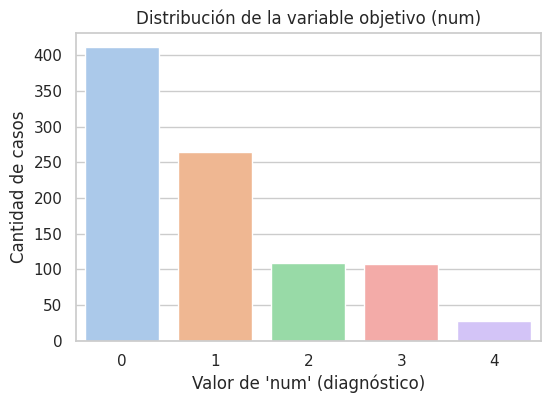

In [ ]:
# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='num', palette="pastel")
plt.title("Distribución de la variable objetivo (num)")
plt.xlabel("Valor de 'num' (diagnóstico)")
plt.ylabel("Cantidad de casos")
plt.show()


### Análisis de la variable objetivo

La variable `num` representa el diagnóstico final para cada paciente y toma valores entre 0 y 4. La visualización muestra que:

- La clase **0** (sin enfermedad) es la más frecuente, con más de 400 casos.
- La clase **1** también está bien representada.
- Las clases **2**, **3** y especialmente **4** tienen una frecuencia mucho menor.

Dado este desbalance y considerando que en la práctica muchas aplicaciones clínicas se centran en determinar **presencia o ausencia de enfermedad**, tomaremos la decisión de convertir esta variable en un problema de **clasificación binaria**:

- `0`: Sin enfermedad (clase 0)
- `1, 2, 3, 4` : Con enfermedad (clase 1)

Esta transformación simplificará el problema, mejorará la estabilidad del entrenamiento, y facilitará la interpretación de los resultados en la etapa de evaluación del modelo.


<ipython-input-5-fa8f9d94e662>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='enfermo', palette="pastel")


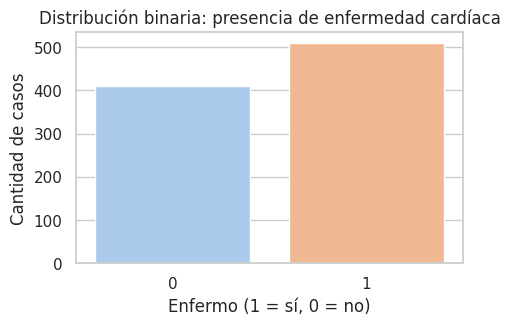

In [ ]:
# Creamos una nueva columna binaria: 'enfermo'
df['enfermo'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Visualizamos su distribución
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='enfermo', palette="pastel")
plt.title("Distribución binaria: presencia de enfermedad cardíaca")
plt.xlabel("Enfermo (1 = sí, 0 = no)")
plt.ylabel("Cantidad de casos")
plt.show()


### Transformación binaria

La nueva variable `enfermo` resume la información del diagnóstico original en una forma más simple y útil para entrenar un modelo de clasificación binaria:

- Valor **0**: el paciente no presenta indicios de enfermedad cardíaca.
- Valor **1**: el paciente presenta algún grado de afección.

La visualización muestra que las clases están **relativamente balanceadas**, con una ligera mayoría de casos positivos (enfermos). Esta distribución es favorable para entrenar modelos sin necesidad inmediata de aplicar técnicas de resampling como oversampling o undersampling.

En las próximas etapas utilizaremos `enfermo` como variable objetivo, y descartaremos `num`, que ya no será necesaria.


<ipython-input-6-efac9a3afc5f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valores_nulos.values, y=valores_nulos.index, palette="rocket")


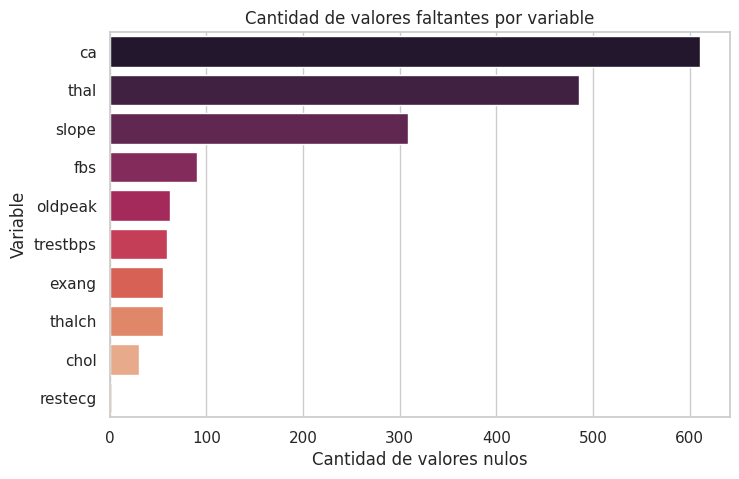

In [ ]:
# Calculamos cantidad de valores nulos por columna
valores_nulos = df.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(x=valores_nulos.values, y=valores_nulos.index, palette="rocket")
plt.title("Cantidad de valores faltantes por variable")
plt.xlabel("Cantidad de valores nulos")
plt.ylabel("Variable")
plt.show()


### Análisis de valores faltantes

El gráfico anterior muestra que varias columnas presentan valores nulos, pero con niveles muy distintos de afectación:

- Las variables más comprometidas son:
  - `ca` (vasos coloreados): más de **600 valores faltantes**.
  - `thal` (resultado de prueba de talio): más de **500 valores nulos**.
  - `slope` (pendiente del segmento ST): más de **300 ausencias**.

Estas tres variables deberán analizarse con especial atención: podríamos imputarlas si su información es relevante o directamente descartarlas si comprometen la calidad del análisis.

- Otras variables como `fbs`, `oldpeak`, `trestbps`, `chol` y `thalch` tienen **menos del 10% de datos faltantes**, por lo que probablemente podamos imputarlas con técnicas simples (media, moda, etc.).

Ahora analizaremos el tipo de cada variable (numérica o categórica) y propondremos un enfoque adecuado para completar los valores ausentes, garantizando así un dataset consistente antes de pasar al modelado.


In [ ]:
# Separamos las columnas según su tipo de dato
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_categoricas = df.select_dtypes(include='object').columns.tolist()

# Mostramos las listas (excluyendo 'id' y 'num' que no usaremos como predictores)
print("Variables numéricas:")
print([col for col in variables_numericas if col not in ['id', 'num']])

print("\nVariables categóricas:")
print(variables_categoricas)


Variables numéricas:
['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'enfermo']

Variables categóricas:
['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


### Clasificación de variables por tipo

A partir de la estructura interna del dataset, identificamos:

- **Variables numéricas**: `age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`, `enfermo`.  
  Estas variables serán candidatas a **imputación numérica** (por media o mediana), y posteriormente a **escalado** si el modelo lo requiere.

- **Variables categóricas**: `sex`, `dataset`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `thal`.  
  Estas variables requerirán **imputación categórica** (por moda, por ejemplo) y luego **codificación** (como OneHotEncoding o similar).

**Importante:**
- La variable `enfermo` es nuestra **variable objetivo** y no debe ser transformada junto con las predictoras.
- Las variables `id` y `dataset` no serán utilizadas para predecir, ya que no aportan valor informativo o podrían inducir sesgos.

Ahora comenzaremos a preparar un pipeline de preprocesamiento que automatice todo este flujo: imputación, codificación y escalado, dejando los datos listos para el entrenamiento del modelo.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Variables que usaremos como predictoras (excluimos id, dataset, num, enfermo)
variables_numericas = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Pipeline para variables numéricas: imputación por media + escalado
pipeline_numerico = Pipeline(steps=[
    ('imputacion', SimpleImputer(strategy='mean')),
    ('escalado', StandardScaler())
])

# Pipeline para variables categóricas: imputación por moda + codificación one-hot
pipeline_categorico = Pipeline(steps=[
    ('imputacion', SimpleImputer(strategy='most_frequent')),
    ('codificacion', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline general de preprocesamiento
preprocesador = ColumnTransformer(transformers=[
    ('num', pipeline_numerico, variables_numericas),
    ('cat', pipeline_categorico, variables_categoricas)
])


### Definición del pipeline de preprocesamiento

Necesitamos construir un pipeline que automatize el tratamiento de las variables predictoras, diferenciando dos caminos:

- Para las **variables numéricas**:
  - Aplicamos imputación por **media**, una estrategia simple y efectiva cuando los valores faltantes son pocos y los datos no están sesgados.
  - Luego estandarizamos estas variables con `StandardScaler`, dejándolas con media 0 y desviación estándar 1, lo cual es útil para muchos algoritmos de clasificación.

- Para las **variables categóricas**:
  - Usamos imputación por **moda** (`most_frequent`), ya que en este tipo de variables tiene sentido reemplazar valores faltantes por la categoría más común.
  - Luego aplicamos **OneHotEncoding**, que convierte cada categoría en una columna binaria, evitando así asignar relaciones numéricas artificiales entre categorías.

Este pipeline fue ensamblado con `ColumnTransformer`, que nos permite aplicar transformaciones distintas según el tipo de dato, y dejar el dataset listo para ser usado por cualquier modelo.

En la siguiente celda vamos a aplicar este preprocesador a los datos, para transformar el conjunto completo y verificar que todo funcione correctamente.


In [ ]:
# Definimos las columnas que vamos a usar como features
columnas_a_utilizar = variables_numericas + variables_categoricas

# Aplicamos el pipeline de preprocesamiento a esas columnas
X_transformado = preprocesador.fit_transform(df[columnas_a_utilizar])

# Mostramos la forma del resultado y un pequeño fragmento
print(f"Forma del array transformado: {X_transformado.shape}")

# Si queremos ver algunas filas como DataFrame:
X_transformado_df = pd.DataFrame(X_transformado.toarray() if hasattr(X_transformado, "toarray") else X_transformado)
X_transformado_df.head()


Forma del array transformado: (920, 25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.007386,0.698041,0.311021,0.495698,1.349421,-1.249371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.432034,1.511761,0.797713,-1.175955,0.589832,4.292099,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.432034,-0.658158,0.274289,-0.340128,1.634267,2.444942,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.752828,-0.115679,0.467130,1.968345,2.488805,-1.249371,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.328180,-0.115679,0.044717,1.371326,0.494884,-1.249371,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Preprocesamiento aplicado con éxito

La aplicación del pipeline sobre las variables predictoras fue exitosa. El dataset fue transformado en una matriz de **920 filas y 25 columnas**, resultado de:

- La imputación y estandarización de las 6 variables numéricas seleccionadas.
- La codificación one-hot de las variables categóricas, que se expandieron en múltiples columnas binarias.

El resultado es una versión completamente **preparada del conjunto de datos**, lista para ser utilizada en algoritmos de clasificación. No contiene valores nulos, ni categorías sin codificar, ni escalas incompatibles.

## Conclusión y cierre

En el próximo cuaderno utilizaremos este dataset transformado para:

- Entrenar y comparar modelos supervisados.
- Evaluar su rendimiento utilizando métricas adecuadas (accuracy, F1, ROC).
- Visualizar resultados y justificar decisiones de modelado.

Este trabajo constituye el paso final del preprocesamiento. A partir de aquí, ya estamos en condiciones de avanzar con la etapa de entrenamiento y análisis de resultados.
